## **A**utomated **L**earning for **I**nsightful **C**omparison and **E**valuation - (ALICE)

For transparency purposes, we are disclosing the data pre-processing Notebook which shows how
the cleaned and upsampled datasets given in `clean_data/class_telco` were obtained.

### Table of Contents:<br>
1) Cleaning<br>
2) Upsampling<br>

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from scipy import stats
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-v0_8')
cur_dir = os.getcwd()


# 1) Data Inspection and Cleaning

In [9]:
# Import the dataset
df = pd.read_excel("Telco_customer_churn.xlsx")

In [ ]:
# General Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

## What the customer churn dataset includes:

**CustomerID**: A unique ID that identifies each customer.

**Count**: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

**Country**: The country of the customer’s primary residence.

**State**: The state of the customer’s primary residence.

**City**: The city of the customer’s primary residence.

**Zip Code**: The zip code of the customer’s primary residence.

**Lat Long**: The combined latitude and longitude of the customer’s primary residence.

**Latitude**: The latitude of the customer’s primary residence.

**Longitude**: The longitude of the customer’s primary residence.

**Gender**: The customer’s gender: Male, Female

**Senior Citizen**: Indicates if the customer is 65 or older: Yes, No

**Partner**: Indicate if the customer has a partner: Yes, No

**Dependents**: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

**Tenure Months**: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

**Phone Service**: Indicates if the customer subscribes to home phone service with the company: Yes, No

**Multiple Lines**: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

**Internet Service**: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

**Online Security**: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

**Online Backup**: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

**Tech Support**: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

**Streaming TV**: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Streaming Movies**: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

**Contract**: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

**Paperless Billing**: Indicates if the customer has chosen paperless billing: Yes, No

**Payment Method**: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

**Monthly Charge**: Indicates the customer’s current total monthly charge for all their services from the company.

**Total Charges**: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

**Churn Label**: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

**Churn Value**: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

**Churn Score**: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

**CLTV**: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

**Churn Reason**: A customer’s specific reason for leaving the company. Directly related to Churn Category.

In [25]:
# replacing white spaces in column names with nothing
df.columns = df.columns.str.replace(" ", "")

Dropping variables we do not need:

In [26]:

initial_dataframe_columns = len(df.columns)

# We do not need Churn Label as it is the same as Churn Value
df.drop("ChurnLabel", axis=1, inplace=True)

# Drop customerId if its unique values == length of dataset
if df["CustomerID"].nunique() == len(df):
    print("Dropping CustomerID as no duplicate values observed:")
    df.drop("CustomerID", axis=1, inplace=True)
else:
    print("There are duplicate customer id values")

# Dropping Cities
df.drop("City", axis=1, inplace=True)

# Dropping country because every obseration is from U.S.
df.drop("Country", axis=1, inplace=True)

# Dropping state because every observation is from California
df.drop("State", axis=1, inplace=True)

df.drop("ZipCode", axis=1, inplace=True)

# Dropping count as its useless
df.drop("Count", axis=1, inplace=True)

# Drop LatLong as it just inclodes both Latitude and Longitude Together as a string
df.drop("LatLong", axis=1, inplace=True)

# Dropping ChurnReason for obvious reasons
df.drop("ChurnReason", axis=1, inplace=True)

print(
    f"\nDataframe columns reduced from {initial_dataframe_columns} to "
    f"{len(df.columns)}."
)

Dropping CustomerID as no duplicate values observed:

Dataframe columns reduced from 33 to 24.


Identifying categorical variables:

In [27]:
# We can begin by looking for categorial variables in the dataset
cat_col = [feature for feature in df.columns if df[feature].dtype == "object"]

print(f"The following features are categorical:")
print("-"*100)
for feature in cat_col:
    print(feature)
print("-"*100)

The following features are categorical:
----------------------------------------------------------------------------------------------------
Gender
SeniorCitizen
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
TotalCharges
----------------------------------------------------------------------------------------------------


Now we can identify which of the features are binary, and which are multi-class: 

In [28]:
# Any variable that has 2 unique values is obviously a binary feature
binary_features = [
    feature for feature in df[cat_col] if df[feature].nunique() == 2
]
# Anything else falls in multiclass
multiclass_features = [
    feature for feature in df[cat_col] if feature not in binary_features
]

print(f"We have the following binary features:")
for feature in binary_features:
    print(feature)
print("-"*100)
print(f"We have the following multi-class features:")
for feature in multiclass_features:
    print(feature)

We have the following binary features:
Gender
SeniorCitizen
Partner
Dependents
PhoneService
PaperlessBilling
----------------------------------------------------------------------------------------------------
We have the following multi-class features:
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod
TotalCharges


We can now look at the unique values of the multi-class categorical features:

In [29]:
df[multiclass_features].nunique()

MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaymentMethod          4
TotalCharges        6531
dtype: int64

As long as there are no missing values, we can just encode everything that has 3 or four as dummies.

In [30]:
if all(df.isna().sum()) == 0:
    print("There are no missing values.")

There are no missing values.


In [31]:
features_to_dummify = [feature for feature in multiclass_features if df[feature].nunique() < 5]
print("We will just generate dummies for the following features:")
for feature in features_to_dummify:
    print(feature)

We will just generate dummies for the following features:
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaymentMethod


In [32]:
for feature in features_to_dummify:
    print(f"{feature} Values:")
    print(df[feature].value_counts(dropna=False))
    print("-"*100)

MultipleLines Values:
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
----------------------------------------------------------------------------------------------------
InternetService Values:
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
----------------------------------------------------------------------------------------------------
OnlineSecurity Values:
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
----------------------------------------------------------------------------------------------------
OnlineBackup Values:
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
----------------------------------------------------------------------------------------------------
DeviceProtection Values:
No                     3095
Yes         

In [33]:
features_to_dummify

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [34]:
# Obtain dummies, drop first
dummies = pd.get_dummies(df[features_to_dummify], drop_first=True)

# Replace white spaces
dummies.columns = dummies.columns.str.replace(" ", "_")

print(dummies.columns)

Index(['MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'InternetService_Fiber_optic', 'InternetService_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'OnlineBackup_No_internet_service', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'TechSupport_No_internet_service', 'TechSupport_Yes',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check'],
      dtype='object')


In [35]:
# Now add these to dataframe and drop the original ones
df = pd.concat([df, dummies], axis=1)
print(f"After concatenation there were {len(df.columns)} columns.")

# Drop the original variables
df.drop(features_to_dummify, axis=1, inplace=True)
print(
    f"After dropping the original variables "
    f"there were {len(df.columns)} columns."
)
print(f"Operation successful if difference is {len(features_to_dummify)}")


After concatenation there were 45 columns.
After dropping the original variables there were 35 columns.
Operation successful if difference is 10


In [36]:
# Re generate multiclass features
multiclass_features = [
    feature for feature in multiclass_features if feature not in features_to_dummify
]

print(f"Remaining multiclass features:")
print("-"*100)
for feature in multiclass_features:
    print(feature)

Remaining multiclass features:
----------------------------------------------------------------------------------------------------
TotalCharges


In [37]:
df[multiclass_features].dtypes

TotalCharges    object
dtype: object

TotalCharges should be a numerical feature so we shoud inspect and transform it to a float datatype instead:

In [38]:
df['TotalCharges']

0        108.15
1        151.65
2         820.5
3       3046.05
4        5036.3
         ...   
7038     1419.4
7039     1990.5
7040     7362.9
7041     346.45
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object

In [39]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

Now we check if there are missing values as a result and if yes we can drop those rows.

In [40]:
nan_rows = df[df['TotalCharges'].isna()]
nan_rows

,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
2234,34.084909,-117.258107,Female,No,Yes,No,0,No,Yes,52.55,...,1,0,1,0,0,0,1,0,0,0
2438,36.869584,-118.189241,Male,No,No,No,0,Yes,No,20.25,...,0,1,0,1,0,0,1,0,0,1
2568,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,80.85,...,0,0,1,0,1,0,1,0,0,1
2667,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,No,25.75,...,0,1,0,1,0,0,1,0,0,1
2856,40.363446,-123.835041,Female,No,Yes,No,0,No,No,56.05,...,1,0,1,0,0,0,1,1,0,0
4331,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,19.85,...,0,1,0,1,0,0,1,0,0,1
4687,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,No,25.35,...,0,1,0,1,0,0,1,0,0,1
5104,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,20.00,...,0,1,0,1,0,0,1,0,0,1
5719,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,Yes,19.70,...,0,1,0,1,0,1,0,0,0,1
6772,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,No,73.35,...,1,0,1,0,0,0,1,0,0,1


In [41]:
## Drop rows with missing values
df = df.dropna(subset=['TotalCharges'])

In [42]:
# Look at the info again
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               7032 non-null   float64
 1   Longitude                              7032 non-null   float64
 2   Gender                                 7032 non-null   object 
 3   SeniorCitizen                          7032 non-null   object 
 4   Partner                                7032 non-null   object 
 5   Dependents                             7032 non-null   object 
 6   TenureMonths                           7032 non-null   int64  
 7   PhoneService                           7032 non-null   object 
 8   PaperlessBilling                       7032 non-null   object 
 9   MonthlyCharges                         7032 non-null   float64
 10  TotalCharges                           7032 non-null   float64
 11  Chur

Let us take care of the binary columns that are still saved as objects

In [43]:
df[binary_features]

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,Male,No,No,No,Yes,Yes
1,Female,No,No,Yes,Yes,Yes
2,Female,No,No,Yes,Yes,Yes
3,Female,No,Yes,Yes,Yes,Yes
4,Male,No,No,Yes,Yes,Yes
...,...,...,...,...,...,...
7038,Female,No,No,No,Yes,Yes
7039,Male,No,Yes,Yes,Yes,Yes
7040,Female,No,Yes,Yes,Yes,Yes
7041,Female,No,Yes,Yes,No,Yes


In [44]:
# Map everything to 1 and 0
# Set up a dictionary where we map
yes_and_no = {
    "Yes": 1,
    "No": 0
}
df["SeniorCitizen"] = df["SeniorCitizen"].map(yes_and_no)
df["Partner"] = df["Partner"].map(yes_and_no)
df["Dependents"] = df["Dependents"].map(yes_and_no)
df["PhoneService"] = df["PhoneService"].map(yes_and_no)
df["PaperlessBilling"] = df["PaperlessBilling"].map(yes_and_no)

In [45]:
# map males to 1 and females to 0
male_female = {
    "Male": 1,
    "Female": 0
}
df['Gender'] = df['Gender'].map(male_female)

In [46]:
df[binary_features]

,Gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
0,1,0,0,0,1,1
1,0,0,0,1,1,1
2,0,0,0,1,1,1
3,0,0,1,1,1,1
4,1,0,0,1,1,1
...,...,...,...,...,...,...
7038,0,0,0,0,1,1
7039,1,0,1,1,1,1
7040,0,0,1,1,1,1
7041,0,0,1,1,0,1


In [47]:
# Check the columns
df.columns

Index(['Latitude', 'Longitude', 'Gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'TenureMonths', 'PhoneService', 'PaperlessBilling',
       'MonthlyCharges', 'TotalCharges', 'ChurnValue', 'ChurnScore', 'CLTV',
       'MultipleLines_No_phone_service', 'MultipleLines_Yes',
       'InternetService_Fiber_optic', 'InternetService_No',
       'OnlineSecurity_No_internet_service', 'OnlineSecurity_Yes',
       'OnlineBackup_No_internet_service', 'OnlineBackup_Yes',
       'DeviceProtection_No_internet_service', 'DeviceProtection_Yes',
       'TechSupport_No_internet_service', 'TechSupport_Yes',
       'StreamingTV_No_internet_service', 'StreamingTV_Yes',
       'StreamingMovies_No_internet_service', 'StreamingMovies_Yes',
       'Contract_One_year', 'Contract_Two_year',
       'PaymentMethod_Credit_card_(automatic)',
       'PaymentMethod_Electronic_check', 'PaymentMethod_Mailed_check'],
      dtype='object')

ChurnValue can be used as binary classification target and ChurnScore as a regression task. 
(But ChurnValue cannot be regarded as ground truth variable.)

In [48]:
## Generate new dataframes after dropping the targets
reg_telco = df.drop('ChurnValue', axis=1)
class_telco = df.drop('ChurnScore', axis=1)

In [49]:
# Save both dataframes with pickle
with open('reg_telco.pkl', 'wb') as f:
    pickle.dump(reg_telco, f)

with open('class_telco.pkl', 'wb') as f:
    pickle.dump(class_telco, f)

In [36]:
class_telco.describe()

,Latitude,Longitude,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,PaperlessBilling,MonthlyCharges,...,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,36.283307,-119.799215,0.504693,0.162400,0.482509,0.230375,32.421786,0.903299,0.592719,64.798208,...,0.290102,0.216155,0.384386,0.216155,0.388367,0.209329,0.239619,0.216297,0.336320,0.228100
std,2.456118,2.157588,0.500014,0.368844,0.499729,0.421103,24.545260,0.295571,0.491363,30.085974,...,0.453842,0.411650,0.486484,0.411650,0.487414,0.406858,0.426881,0.411748,0.472483,0.419637
min,32.555828,-124.301372,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.030915,-121.815412,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,35.587500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.391777,-119.735410,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,70.350000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.227285,-118.043237,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,1.000000,89.862500,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,41.962127,-114.192901,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 2) Upsampling

In [2]:
# Importing the cleaned dataset
with open('class_telco.pkl', 'rb') as f:
    class_telco = pickle.load(f)

In [4]:
# takin a look
class_telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 34 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Latitude                               7032 non-null   float64
 1   Longitude                              7032 non-null   float64
 2   Gender                                 7032 non-null   int64  
 3   SeniorCitizen                          7032 non-null   int64  
 4   Partner                                7032 non-null   int64  
 5   Dependents                             7032 non-null   int64  
 6   TenureMonths                           7032 non-null   int64  
 7   PhoneService                           7032 non-null   int64  
 8   PaperlessBilling                       7032 non-null   int64  
 9   MonthlyCharges                         7032 non-null   float64
 10  TotalCharges                           7032 non-null   float64
 11  Chur

In [5]:
## Train-test split
# We need to do the train test split already so that
# we can upsample the training set only
train, test = train_test_split(
    class_telco,
    test_size=0.2,
    random_state=66  # for reproducibility
)

We can inspect a barplot:

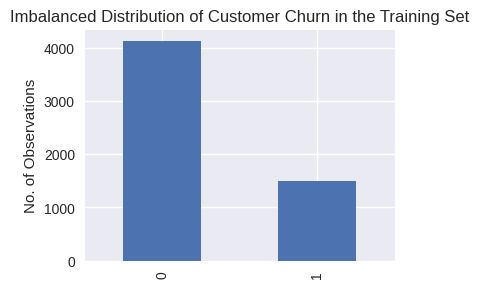

In [12]:
plt.figure(figsize=(4, 3))
train['ChurnValue'].value_counts().plot(kind='bar')
plt.title('Imbalanced Distribution of Customer Churn in the Training Set')
plt.ylabel('No. of Observations')
plt.show()
plt.close()

We can do upsampling using Synthetic Minority Oversampling Technique (SMOTE):

In [13]:
# Separate target and predictors
X_train = train.drop("ChurnValue", axis=1)
y_train = train["ChurnValue"]

# Initialize upsampling using automatic strategy
smote = SMOTE(
    sampling_strategy='auto',
    random_state=66
)

# Fit resampler on the training set only
X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train,
    y_train
)

# Generate upsampled training set
train_resampled = pd.concat([X_train_resampled, y_train_resampled], axis=1)


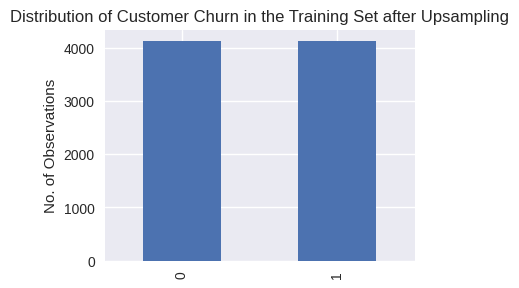

In [14]:
# Inspect the resolved imbalance via a barplot

plt.figure(figsize=(4,3))
train_resampled["ChurnValue"].value_counts().plot(kind="bar")
plt.title("Distribution of Customer Churn in the Training Set after Upsampling")
plt.ylabel("No. of Observations")
plt.show()
plt.close()

In [2]:
## Set up paths

raw_train_path = "clean_data/class_telco/raw_train.pkl"
upsampled_train_path = "clean_data/class_telco/upsampled_train.pkl"
test_path = "clean_data/class_telco/test.pkl"


In [17]:
## SAVE THE FILES

# Save the training set in its original form (not upsampled)
with open(raw_train_path, "wb") as f:
    pickle.dump(train, f)

# Save the upsampled training set
with open(upsampled_train_path, "wb") as f:
    pickle.dump(train_resampled, f)

# Save the test set (not upsampled)
with open(test_path, "wb") as f:
    pickle.dump(test, f)
